In [1]:
import pandas as pd
from robo_trader import Trader
from robo_trader.feeds import YFinanceFeed
import json
import matplotlib.pyplot as plt

In [9]:
from robo_trader.strategy import Strategy
from robo_trader.portfolio import Portfolio
from advanced_ta import LorentzianClassification
from ta.volume import money_flow_index as MFI
import pandas as pd
import warnings
from dataclasses import dataclass

# Suppress specific warning from numpy
warnings.filterwarnings("ignore", message="All-NaN slice encountered")

@dataclass
class LorentzianSettings:
    position_size: float = 1
    trailing_stop: float = 0.05
    take_profit: float = 0.1

class LorentzianStrategy(Strategy):
    def __init__(self, settings: LorentzianSettings):
        super().__init__()
        self.settings = settings

    def evaluate_market(self, symbol: str, prices: pd.DataFrame, portfolio: Portfolio):
        min_data_for_adx = max(20, 20) * 2
        if (True or False) and len(prices) <= min_data_for_adx:
            return

        lc = self.get_lorentzian_predictions(prices)        
        last_price_point_prediction = lc.data.iloc[-1]

        if not pd.isna(last_price_point_prediction['startLongTrade']):
            portfolio.open_long(symbol, self.settings.position_size, self.settings.trailing_stop, self.settings.take_profit)

    def get_lorentzian_predictions(self, prices):
        lc = LorentzianClassification(
            prices,    
            [
                LorentzianClassification.Feature("RSI", 24, 1),
                #LorentzianClassification.Feature("WT", 10, 11),
                LorentzianClassification.Feature("CCI", 24, 1),
                #LorentzianClassification.Feature("ADX", 48, 1),
                #MFI(prices['high'], prices['low'], prices['close'], prices['volume'], 14)
            ],
            settings=LorentzianClassification.Settings(
                source='close',
                neighborsCount=8,
                maxBarsBack=2000,
                useDynamicExits=False
            ),
            filterSettings=LorentzianClassification.FilterSettings(
                useVolatilityFilter=False,
                useRegimeFilter=True,
                useAdxFilter=False,
                regimeThreshold=-0.1,
                adxThreshold=30,
                adxLength=24,
                kernelFilter = LorentzianClassification.KernelFilter(
                    useKernelSmoothing=False,
                    lookbackWindow=8,
                    relativeWeight=8.0,
                    regressionLevel=25,
                    crossoverLag=0
                )
            )
        )

        return lc

In [10]:
# SYMBOL = "BTC-GBP"
# train_since = datetime(2016, 7, 1, tzinfo=timezone.utc)
# start_date = datetime(2018, 7, 1, tzinfo=timezone.utc)
# end_date = datetime(2019, 7, 1, tzinfo=timezone.utc)
# interval = Interval.ONE_DAY
# period = 28

SYMBOL = "BTC-GBP"
train_since = pd.to_datetime('2022-09-01').tz_localize('UTC')
start_date = pd.to_datetime('2022-12-01').tz_localize('UTC')
end_date = pd.to_datetime('2024-08-01').tz_localize('UTC')
period = 168
invert_pair = True

feed = YFinanceFeed(interval = '1h', invert_pair=invert_pair)

settings = LorentzianSettings()
strategy = LorentzianStrategy(settings)

# Create a Trader instance with the strategy
trader = Trader(SYMBOL, 1000, feed, strategy)

In [11]:
# Run the backtest
portfolio = trader.backtest(start_date, end_date, period, train_since, transaction_cost=0.004, trailing_stop_penalty_relief=0.9)

Request to open long position on BTC-GBP
    Opening long position for BTC-GBP with for 100% of the cash (£1000)
    Creating MARKET BUY order for BTC-GBP at 7.112850301799488e-05 with quantity 14002825.277343752, trail None, limit None, stop None, take_profit None
    Executing MARKET BUY order for BTC-GBP at 7.112850301799488e-05 with quantity 14002825.277343752, total cost £999.984 and transaction cost £3.984
        Bought 14002825.277343752 BTC-GBP at 7.112850301799488e-05 on 01/12/2022 11:00
    Creating TRAILING_STOP SELL order for BTC-GBP at 7.112850301799488e-05 with quantity 14002825.277343752, trail 0.05, limit None, stop None, take_profit None
    Updated trailing stop to 6.79641811650403e-05
    Creating TRAILING_STOP SELL order for BTC-GBP at 7.152060631594005e-05 with quantity 14002825.277343752, trail 0.04925472301410172, limit None, stop None, take_profit None
Updated trailing stop for BTC-GBP to 0.00 (trail: 4.93%)
    Updated trailing stop to 6.825428472049272e-05
  

Win Rate: 0.41
Initial Value: 1000.00
Final Value: 685.29
Portfolio Return: -0.3147
Asset Return: -0.7183


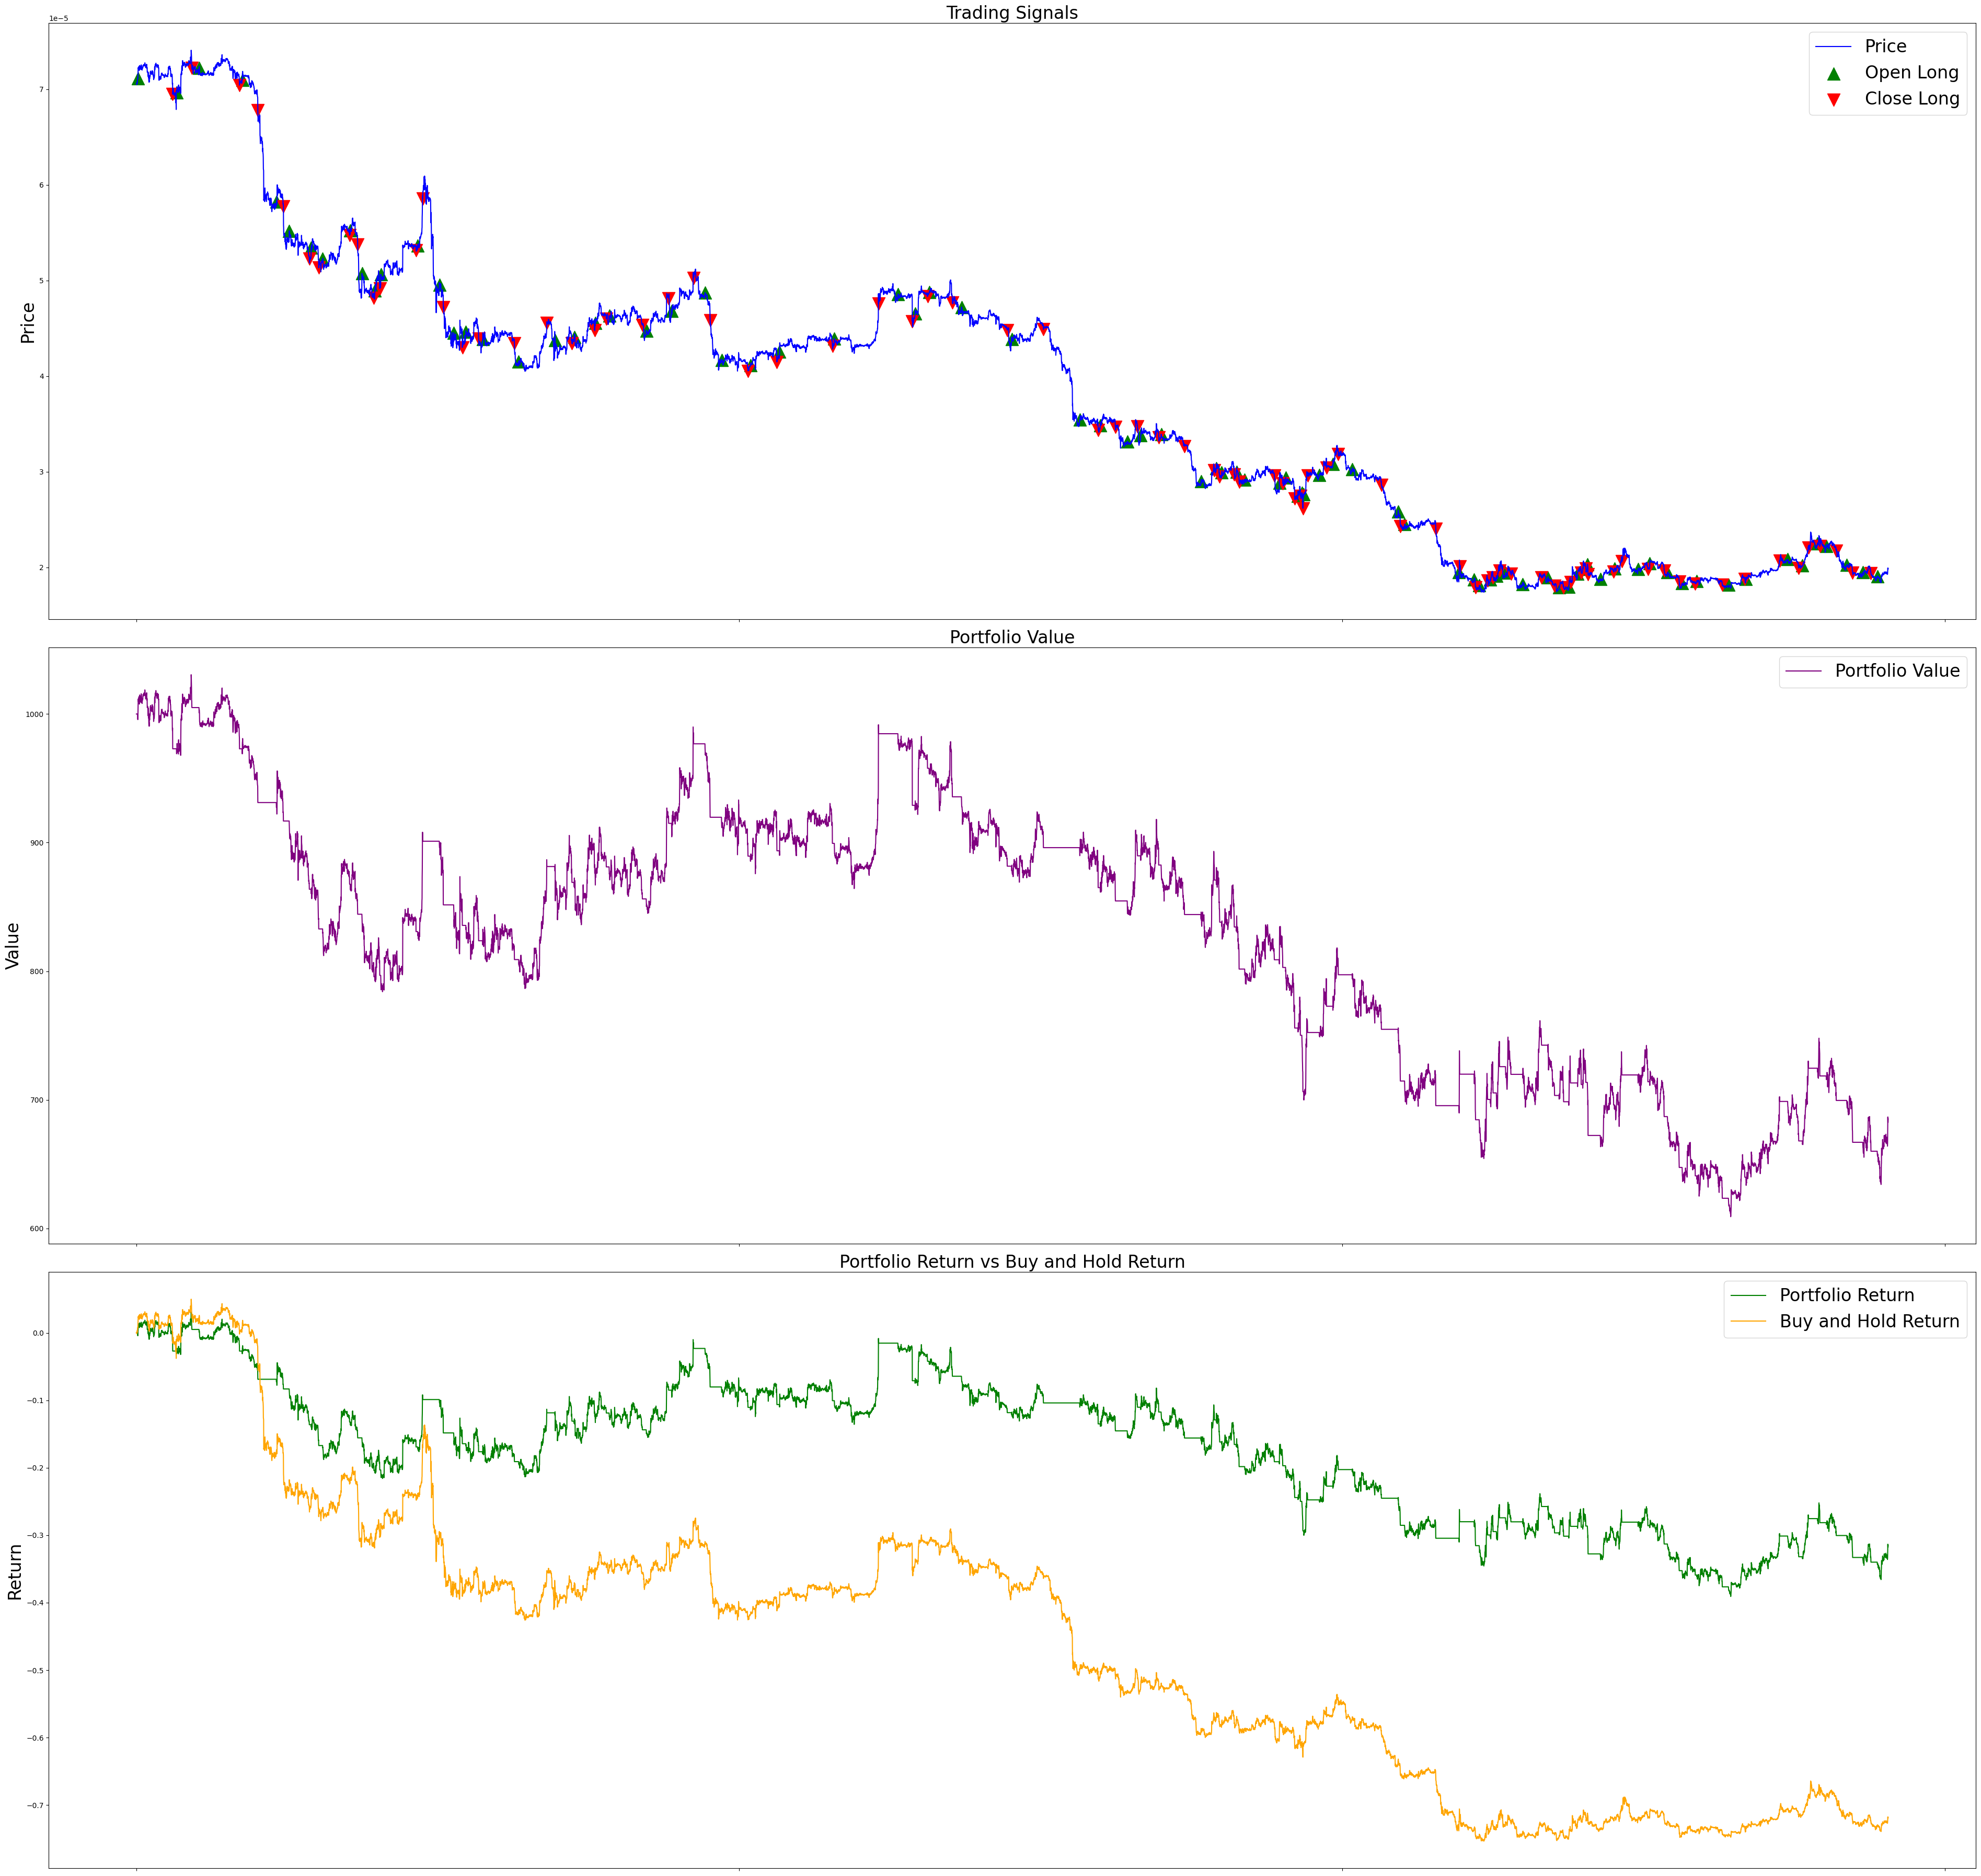

In [12]:
perf = portfolio.plot_performance()

In [13]:
import csv
import os

# Define the CSV file path
csv_file = 'lorentzian.csv'

# Define the header
header = ['train_since', 'start_date', 'end_date', 'period', 'invert_pair', 'win_rate', 'portfolio_return', 'asset_return', 'portfolio_max_drawdown', 'asset_max_drawdown']

# Check if file exists and is empty
file_exists = os.path.isfile(csv_file)
file_empty = os.stat(csv_file).st_size == 0 if file_exists else True

# Open the file in append mode
with open(csv_file, 'a', newline='') as f:
    writer = csv.writer(f)
    
    # Write header if file is empty or doesn't exist
    if not file_exists or file_empty:
        writer.writerow(header)
    
    # Write the performance data
    writer.writerow([train_since, start_date, end_date, period, invert_pair, perf['win_rate'], perf['portfolio_return'], perf['asset_return'], perf['portfolio_max_drawdown'], perf['asset_max_drawdown']])

print(f"Performance data appended to {csv_file}")


Performance data appended to lorentzian.csv
